**Pipeline**

*Transfomer* : filtering or modifying the data, has a 'fit' and 'transform' method <br>
*Estimator* : learning from data, has a 'fit' and 'predict' method

In [27]:
'''
 A pipeline that first classifies whether a given
 flight will be delayed and then predicts the arrival delay
 period for those flights that are classified as delayed,
'''

'\n A pipeline that first classifies whether a given\n flight will be delayed and then predicts the arrival delay\n period for those flights that are classified as delayed,\n'

In [95]:
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import seaborn as sns
import numpy as np

In [96]:
classification_data = pd.read_csv("data_classification_before_smote.csv")
regression_data = pd.read_csv("data_for_regression_before_smote.csv")

In [97]:
classification_data = classification_data.drop(['Unnamed: 0', 'CRSArrTime', 'ArrTime'], axis = 1)

In [98]:
X = classification_data.drop(['ArrDel15'], axis = 1)
Y = classification_data['ArrDel15']

In [99]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [100]:
smote = SMOTE(random_state=42)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

In [101]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, Y_train.values.ravel())
Y_pred_xgb = xgb_model.predict(X_test)

In [102]:
accuracy_xgb = accuracy_score(Y_test, Y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb}")

XGBoost Accuracy: 0.9134781216571216


In [103]:
predicted_delay = xgb_model.predict(X)

In [104]:
regression_data = regression_data.drop(['Unnamed: 0','CRSArrTime', 'ArrTime','ArrDel15'], axis = 1)

In [105]:
regression_data['predicted_delay'] = predicted_delay

In [106]:
regression_data = regression_data[regression_data['predicted_delay']==1]

In [107]:
regression_data.columns

Index(['Year', 'Month', 'DayofMonth', 'OriginAirportID', 'DestAirportID',
       'DepDelayMinutes', 'DepDel15', 'ArrDelayMinutes', 'rounded_CRSDepTime',
       'WindSpeedKmph', 'WindDirDegree', 'WeatherCode', 'precipMM',
       'Visibilty', 'Pressure', 'Cloudcover', 'WindChillF', 'Humidity',
       'predicted_delay'],
      dtype='object')

In [108]:
X_reg = regression_data.drop(['ArrDelayMinutes', 'predicted_delay'], axis = 1)
Y_reg = regression_data['ArrDelayMinutes']

In [109]:
X_reg.shape,Y_reg.shape

((335409, 17), (335409,))

In [110]:
X_reg_train, X_reg_test, Y_reg_train, Y_reg_test = train_test_split(X_reg, Y_reg, test_size=0.3)

In [111]:
lr_model = LinearRegression()
lr_model.fit(X_reg_train, Y_reg_train)
Y_pred_lr = lr_model.predict(X_reg_test)

In [114]:
mse_lr = mean_squared_error(Y_reg_test, Y_pred_lr)
r2_lr = r2_score(Y_reg_test, Y_pred_lr)
mae_lr = mean_absolute_error(Y_reg_test, Y_pred_lr)
print(f"Linear Regression MSE: {mse_lr}")
print(f"Linear Regression R^2: {r2_lr}")
print(f"Linear Regression MAE: {mae_lr}")

Linear Regression MSE: 329.26829726869494
Linear Regression R^2: 0.945069590933682
Linear Regression MAE: 12.856577096304257


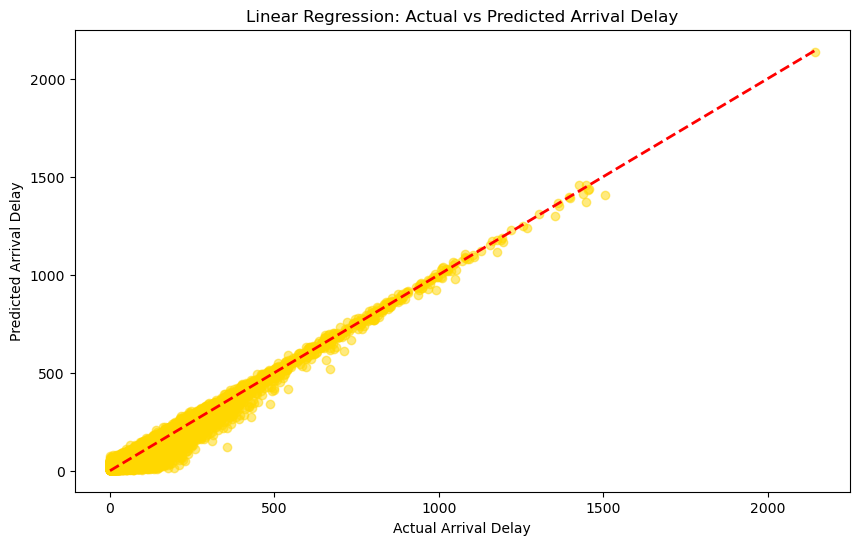

In [113]:
#Linear regression plot
plt.figure(figsize=(10, 6))
plt.scatter(Y_reg_test, Y_pred_lr, alpha=0.5, color='gold')
plt.plot([Y_reg_test.min(), Y_reg_test.max()], [Y_reg_test.min(), Y_reg_test.max()], '--', color='red', linewidth=2)
plt.xlabel('Actual Arrival Delay')
plt.ylabel('Predicted Arrival Delay')
plt.title('Linear Regression: Actual vs Predicted Arrival Delay')
plt.show()

In [116]:
xgb_reg_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
xgb_reg_model.fit(X_reg_train, Y_reg_train.values.ravel())
Y_pred_xgb_reg = xgb_reg_model.predict(X_reg_test)

In [117]:
mse_xgb_reg = mean_squared_error(Y_reg_test, Y_pred_xgb_reg)
r2_xgb_reg = r2_score(Y_reg_test, Y_pred_xgb_reg)
mae_xgb_reg = mean_absolute_error(Y_reg_test, Y_pred_xgb_reg)
print(f"XGBoost Regressor MSE: {mse_xgb_reg}")
print(f"XGBoost Regressor R^2: {r2_xgb_reg}")
print(f"XGBoost Regressor MAE: {mae_xgb_reg}")

XGBoost Regressor MSE: 514.8283064804663
XGBoost Regressor R^2: 0.9141134153865581
XGBoost Regressor MAE: 12.857497929645604


In [118]:
# Calculate adjusted R-squared
n = X_reg_test.shape[0]  # number of observations
k = X_reg_test.shape[1]  # number of independent variables
r2_adj_xgb_reg = 1 - ((1 - r2_xgb_reg) * (n - 1) / (n - k - 1))
print(f"XGBoost Regressor Adjusted R^2: {r2_adj_xgb_reg}")

XGBoost Regressor Adjusted R^2: 0.9140989024703171


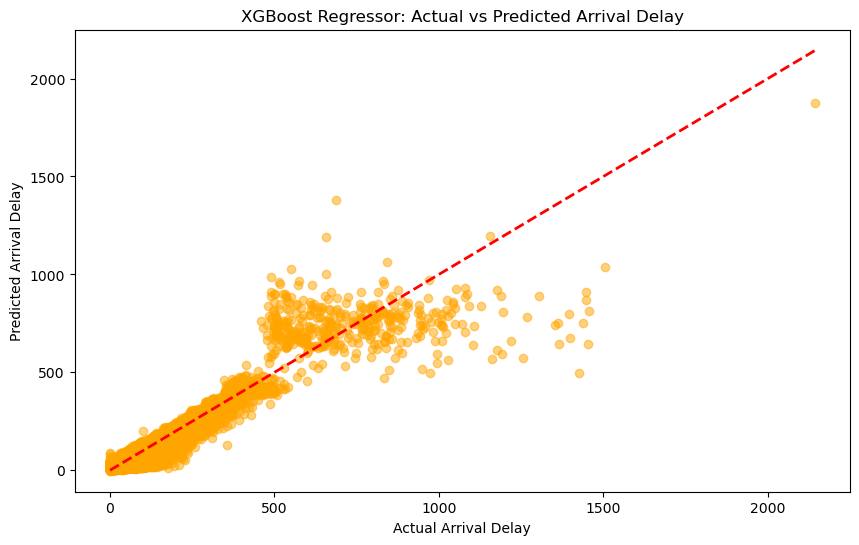

In [119]:
# XGBoost Regressor plot
plt.figure(figsize=(10, 6))
plt.scatter(Y_reg_test, Y_pred_xgb_reg, alpha=0.5, color='orange')
plt.plot([Y_reg_test.min(), Y_reg_test.max()], [Y_reg_test.min(), Y_reg_test.max()], '--', color='red', linewidth=2)
plt.xlabel('Actual Arrival Delay')
plt.ylabel('Predicted Arrival Delay')
plt.title('XGBoost Regressor: Actual vs Predicted Arrival Delay')
plt.show()

In [120]:
et_reg_model = ExtraTreesRegressor()
et_reg_model.fit(X_reg_train, Y_reg_train.values.ravel())
Y_pred_et_reg = et_reg_model.predict(X_reg_test)

In [121]:
mse_et_reg = mean_squared_error(Y_reg_test, Y_pred_et_reg)
mae_et_reg = mean_absolute_error(Y_reg_test, Y_pred_et_reg)
r2_et_reg = r2_score(Y_reg_test, Y_pred_et_reg)
print(f"Extra Trees Regressor MSE: {mse_et_reg}")
print(f"Extra Trees Regressor R^2: {r2_et_reg}")
print(f"Extra Trees Regressor MAE: {mae_et_reg}")

Extra Trees Regressor MSE: 323.16601755499346
Extra Trees Regressor R^2: 0.9460876079237514
Extra Trees Regressor MAE: 12.89461364035393


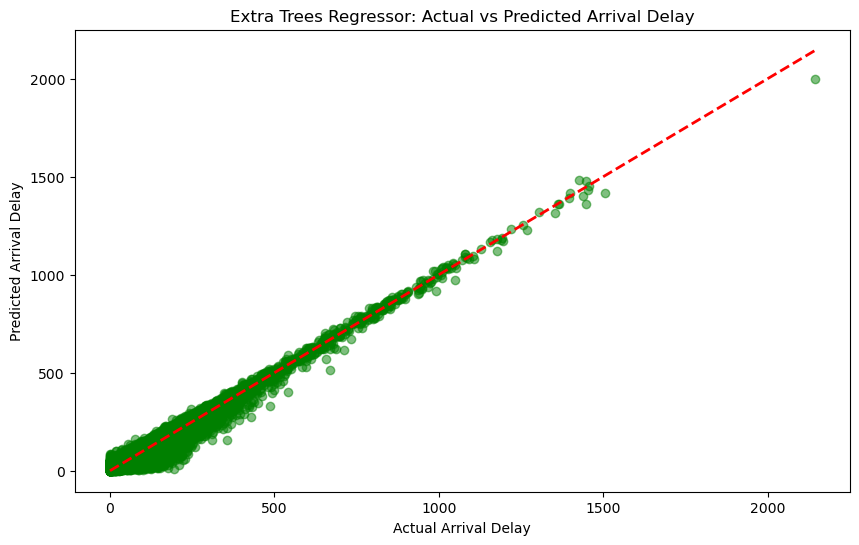

In [122]:
# Extra Trees Regressor plot
plt.figure(figsize=(10, 6))
plt.scatter(Y_reg_test, Y_pred_et_reg, alpha=0.5, color='green')
plt.plot([Y_reg_test.min(), Y_reg_test.max()], [Y_reg_test.min(), Y_reg_test.max()], '--', color='red', linewidth=2)
plt.xlabel('Actual Arrival Delay')
plt.ylabel('Predicted Arrival Delay')
plt.title('Extra Trees Regressor: Actual vs Predicted Arrival Delay')
plt.show()

In [123]:
rf_reg_model = RandomForestRegressor()
rf_reg_model.fit(X_reg_train, Y_reg_train.values.ravel())
Y_pred_rf_reg = rf_reg_model.predict(X_reg_test)

In [124]:
mse_rf_reg = mean_squared_error(Y_reg_test, Y_pred_rf_reg)
r2_rf_reg = r2_score(Y_reg_test, Y_pred_rf_reg)
mae_rf_reg = mean_absolute_error(Y_reg_test, Y_pred_rf_reg)
print(f"Random Forest Regressor MSE: {mse_rf_reg}")
print(f"Random Forest Regressor R^2: {r2_rf_reg}")
print(f"Random Forest Regressor MAE: {mae_rf_reg}")

Random Forest Regressor MSE: 317.28741427757706
Random Forest Regressor R^2: 0.9470683099392374
Random Forest Regressor MAE: 12.77359710239336


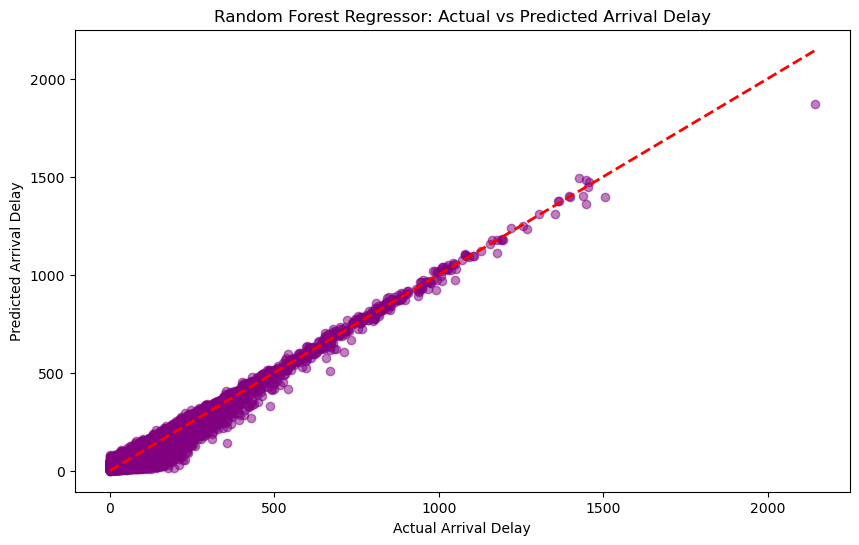

In [125]:
# Random Forest Regressor plot
plt.figure(figsize=(10, 6))
plt.scatter(Y_reg_test, Y_pred_rf_reg, alpha=0.5, color='purple')
plt.plot([Y_reg_test.min(), Y_reg_test.max()], [Y_reg_test.min(), Y_reg_test.max()], '--', color='red', linewidth=2)
plt.xlabel('Actual Arrival Delay')
plt.ylabel('Predicted Arrival Delay')
plt.title('Random Forest Regressor: Actual vs Predicted Arrival Delay')
plt.show()

**FOR OVERALL DATA**

In [129]:
Y_pred_overall = rf_reg_model.predict(X_reg)

In [130]:
rf_reg_model.score(X_reg,Y_reg)

0.9787823595221611

In [131]:
Y_pred_overall = et_reg_model.predict(X_reg)

In [132]:
et_reg_model.score(X_reg,Y_reg)

0.9837461854839867

**Regression Analysis**

In [133]:
predicted_mins = et_reg_model.predict(X_reg)

In [134]:
predicted_mins

array([  0. ,  21. ,  37. , ..., 122. ,  87. ,  72.9])

In [135]:
regression_data['predicted_mins'] = predicted_mins

In [136]:
Y_reg

4            0.0
9           21.0
10          37.0
13         175.0
18          38.0
           ...  
1832206    148.0
1832207     61.0
1832212    122.0
1832240     87.0
1832241     64.0
Name: ArrDelayMinutes, Length: 335409, dtype: float64

In [137]:
regression_data

,Year,Month,DayofMonth,OriginAirportID,DestAirportID,DepDelayMinutes,DepDel15,ArrDelayMinutes,rounded_CRSDepTime,WindSpeedKmph,WindDirDegree,WeatherCode,precipMM,Visibilty,Pressure,Cloudcover,WindChillF,Humidity,predicted_delay,predicted_mins
4,2016,8,27,13204,12892,24.0,1.0,0.0,2100,13,73,113,0.0,10,1016,0,76,77,1,0.00
9,2016,8,27,11292,11298,25.0,1.0,21.0,2000,26,237,122,0.0,10,1014,100,76,40,1,21.00
10,2016,8,27,14771,13204,45.0,1.0,37.0,0,11,249,122,0.0,10,1014,95,58,88,1,37.00
13,2016,8,28,11292,14771,190.0,1.0,175.0,1900,8,282,116,0.0,10,1015,48,77,32,1,175.00
18,2016,8,28,13930,13303,23.0,1.0,38.0,700,5,180,353,0.9,10,1020,91,72,96,1,19.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832206,2016,5,20,10397,12889,135.0,1.0,148.0,1800,13,143,389,5.6,6,1016,100,65,88,1,148.00
1832207,2016,5,20,12889,10397,85.0,1.0,61.0,2200,34,243,113,0.0,10,1005,9,75,30,1,61.00
1832212,2016,5,20,11292,14771,115.0,1.0,122.0,1900,8,52,356,2.7,8,1005,91,67,64,1,122.00
1832240,2016,5,20,12889,14771,88.0,1.0,87.0,1600,36,223,122,0.0,10,1001,74,82,10,1,87.00


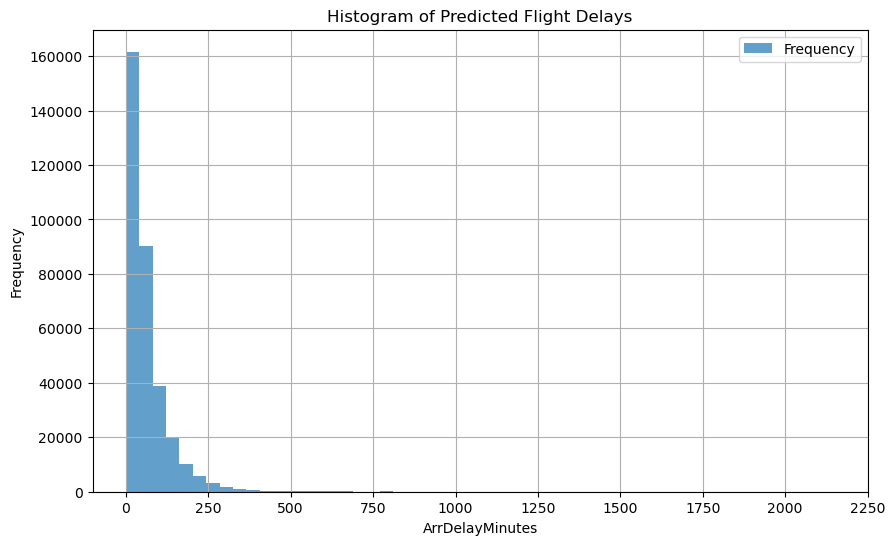

In [138]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(regression_data['predicted_mins'], bins=50, alpha=0.7, label='Frequency')

# Set title and labels
plt.title('Histogram of Predicted Flight Delays')
plt.xlabel('ArrDelayMinutes')
plt.ylabel('Frequency')
plt.legend()

# Set x-axis ticks to increase by 250
plt.xticks(range(0, int(regression_data['predicted_mins'].max()) + 250, 250))

# Add grid
plt.grid(True)

# Show the plot
plt.show()

In [150]:
ranges = [(0, 50), (50, 100), (100, 200), (200, 400), (400, 800), (800, float('inf'))]

results = []

# Loop through each range
for range_min, range_max in ranges:
    # Filter data for the current range
    filtered_data = regression_data[(regression_data['predicted_mins'] > range_min) & (regression_data['predicted_mins'] <= range_max)]
    
    # Get the actual and predicted values
    y_true = filtered_data['ArrDelayMinutes']
    y_pred = filtered_data['predicted_mins']
    
    # Calculate count, MAE, MSE, and RMSE
    count = len(filtered_data)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # Append results
    results.append({
        'Minutes': f"{range_min} - {range_max}",
        'Count': count,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results)

print(results_df)

     Minutes   Count       MAE         MSE       RMSE
0     0 - 50  182268  3.767565   85.252377   9.233221
1   50 - 100   82351  4.097892  108.831460  10.432232
2  100 - 200   46638  4.394075  124.113897  11.140642
3  200 - 400   12995  4.746977  147.648184  12.151057
4  400 - 800    1666  4.929616  160.218706  12.657753
5  800 - inf     459  5.095926  197.933855  14.068897
